In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Softmax, Dropout, Input, MaxPooling2D,GlobalAveragePooling2D,LeakyReLU,ZeroPadding2D,Reshape,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras

In [12]:
EPOCHS = 16
MODEL_FILE = "model.h5"
TRAINING_LOGS_FILE = "training_logs.csv"
VERBOSITY = 1
img_height = 227
img_width = 227
batch_size = 32
data_path = "../dataset/Cropped/"
train_output_directory = "../dataset/Augmented/train/"
validation_output_directory = "../dataset/Augmented/validation/"

In [13]:
input = Input(shape=(img_height, img_width, 3), name="original_img")
# Left Most branch
conv01 = Conv2D(64,(3,3),strides=2,padding='same')(input)
leakyrelu01 = LeakyReLU(0.1)(conv01)
batchnorm01 = BatchNormalization(epsilon=0.00001)(leakyrelu01)
maxpool01 = MaxPooling2D(pool_size=6,strides=3,padding="same")(batchnorm01)
conv02 = Conv2D(128,(3,3),strides=2,padding='same')(maxpool01)
leakyrelu02 = LeakyReLU(0.1)(conv02)
batchnorm02 = BatchNormalization(epsilon=0.00001)(leakyrelu02)
maxpool02 = MaxPooling2D(pool_size=(6,6),strides=3,padding='same')(batchnorm02)
conv03 = Conv2D(224,(3,3),strides=2,padding='same')(maxpool02)
leakyrelu03 = LeakyReLU(0.1)(conv03)
batchnorm03 = BatchNormalization(epsilon=0.00001)(leakyrelu03)
maxpool03 = MaxPooling2D(pool_size=(6,6),strides=3,padding='same')(batchnorm03)

#Fully connected 1
fc_reshape = Reshape((1, 1, -1))(input)
fc01 = Dense(16, activation='relu')(fc_reshape)

leakyrelu01_fc = LeakyReLU(0.1)(fc01)
batchnorm01_fc = BatchNormalization(epsilon=0.00001)(leakyrelu01_fc)
dropout01_fc = Dropout(0.2)(batchnorm01_fc)

zeropadding01 = ZeroPadding2D(padding=(2, 2))(dropout01_fc)
conv05 = Conv2D(64,(3,3),strides=2)(zeropadding01)
leakyrelu05 = LeakyReLU(0.1)(conv05)
batchnorm05 = BatchNormalization(epsilon=0.00001)(leakyrelu05)

zeropadding02 = ZeroPadding2D(padding=(1, 1))(dropout01_fc)
conv04 = Conv2D(32,(2,2),strides=1)(zeropadding02)
leakyrelu04 = LeakyReLU(0.1)(conv04)
batchnorm04 = BatchNormalization(epsilon=0.00001)(leakyrelu04)

depthcat01 = Concatenate()([batchnorm04,batchnorm05])
dropout02 = Dropout(0.2)(depthcat01)

# Combine Both branches
depthcat02 = Concatenate()([dropout02,maxpool03])
dropout03 = Dropout(0.2)(depthcat02)
conv07 = Conv2D(256,(1,1),strides=1,padding='same')(dropout03)
leakyrelu07 = LeakyReLU(0.1)(conv07)
batchnorm07 = BatchNormalization(epsilon=0.00001)(leakyrelu07)
dropout07 = Dropout(0.3)(batchnorm07)

fc02_reshape = Reshape((1, 1, -1))(dropout07)
fc02 = Dense(512)(fc02_reshape)

leakyrelu02_fc = LeakyReLU(0.1)(fc02)
batchnorm02_fc = BatchNormalization(epsilon=0.00001)(leakyrelu02_fc)
dropout02_fc = Dropout(0.3)(batchnorm02_fc)

fc03 = Dense(4,activation='softmax')(dropout02_fc)
final_reshape = Reshape((4,))(fc03)

model = Model(input,final_reshape,name="CCCN")

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "CCCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 original_img (InputLayer)      [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 114, 114, 64  1792        ['original_img[0][0]']           
                                )                                                                 
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 1, 154587  0           ['original_img[0][0]']           
                                )                                                              

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory=data_path,
    save_to_dir=train_output_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=data_path,
    save_to_dir=validation_output_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


In [16]:
MODEL_LAYERS_SIMPLIFIED = "model_plot_simplified.png"
MODEL_LAYERS = "model_plot.png"

# Plot the model layer and save it as a file
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.vis_utils import plot_model
plot_model(model, to_file=MODEL_LAYERS_SIMPLIFIED, show_shapes=True, show_layer_names=True, expand_nested=False)
plot_model(model, to_file=MODEL_LAYERS, show_shapes=True, show_layer_names=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


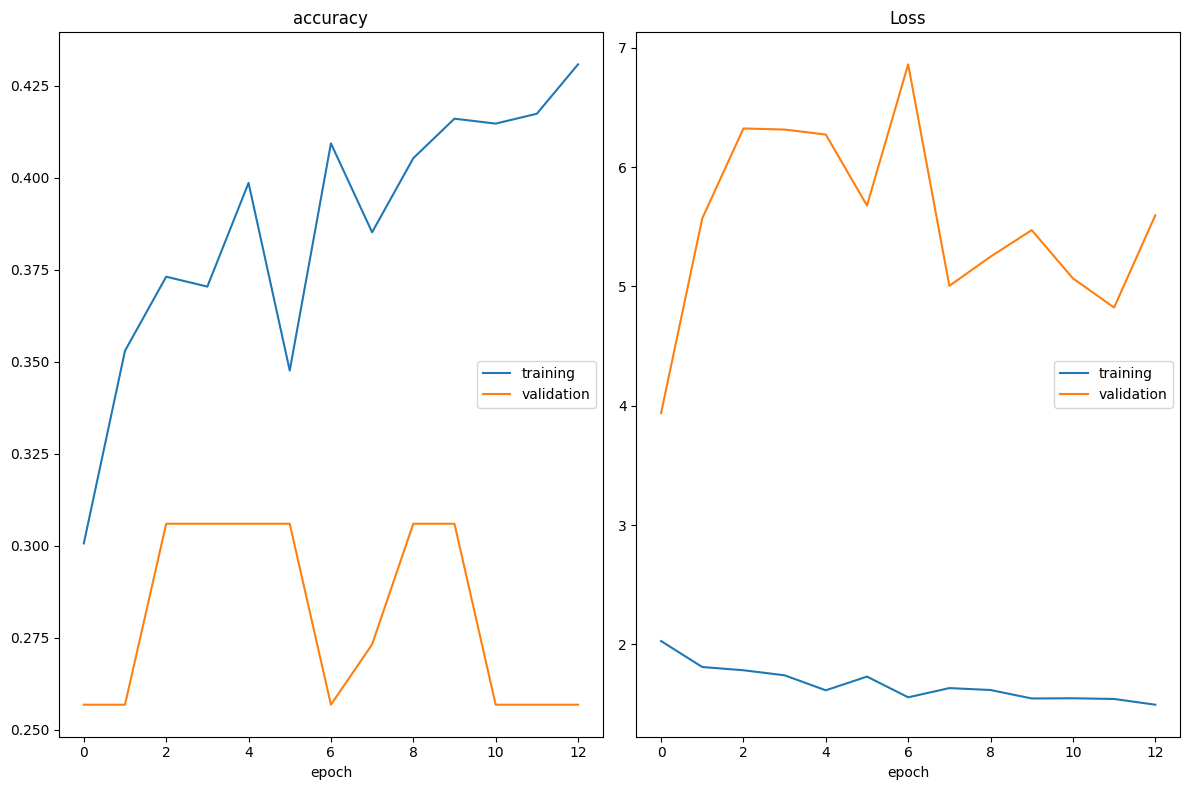

accuracy
	training         	 (min:    0.301, max:    0.431, cur:    0.431)
	validation       	 (min:    0.257, max:    0.306, cur:    0.257)
Loss
	training         	 (min:    1.494, max:    2.027, cur:    1.494)
	validation       	 (min:    3.937, max:    6.861, cur:    5.595)

Epoch 13: val_accuracy did not improve from 0.30601


In [ ]:
# fit the model on data generator 
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          epochs=EPOCHS,
          verbose=VERBOSITY,
          callbacks=[PlotLossesKeras(),
                     ModelCheckpoint(MODEL_FILE,
                                     monitor='val_accuracy',
                                     verbose=VERBOSITY,
                                     save_best_only=True,
                                     mode='max'),
                     CSVLogger(TRAINING_LOGS_FILE,
                               append=False,
                               separator=',')
                    ])